    JACOB KNOPPING
    1/17/2020

## 18.6 Assignment

In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **housing prices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

### SOLUTION

### Loading the housing prices data from database

In [1]:
# import the relevant libraries:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
#load the data from the PostgreSQL database
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

#no need for an open connection (just the one query)
engine.dispose()

#view first 5 rows
houseprices_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


### Data Cleaning: Missing values and Outliers

In [3]:
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns
numeric_columns = houseprices_df.select_dtypes(['int64', 'float64']).columns

In [4]:
houseprices_copy = houseprices_df.copy()
houseprices_df.drop(['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature'], axis=1, inplace=True)

fill_list = list(houseprices_df.columns)
for column in fill_list:
    houseprices_df[column].interpolate(inplace=True)
    
houseprices_df = houseprices_df.fillna(houseprices_df.mode().iloc[0])
houseprices_df.isnull().sum()

id               0
mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
street           0
lotshape         0
landcontour      0
utilities        0
lotconfig        0
landslope        0
neighborhood     0
condition1       0
condition2       0
bldgtype         0
housestyle       0
overallqual      0
overallcond      0
yearbuilt        0
yearremodadd     0
roofstyle        0
roofmatl         0
exterior1st      0
exterior2nd      0
masvnrtype       0
masvnrarea       0
exterqual        0
extercond        0
foundation       0
bsmtqual         0
                ..
bsmtfullbath     0
bsmthalfbath     0
fullbath         0
halfbath         0
bedroomabvgr     0
kitchenabvgr     0
kitchenqual      0
totrmsabvgrd     0
functional       0
fireplaces       0
garagetype       0
garageyrblt      0
garagefinish     0
garagecars       0
garagearea       0
garagequal       0
garagecond       0
paveddrive       0
wooddecksf       0
openporchsf      0
enclosedporch    0
threessnporc

All missing categorical and continous data have been resolved.

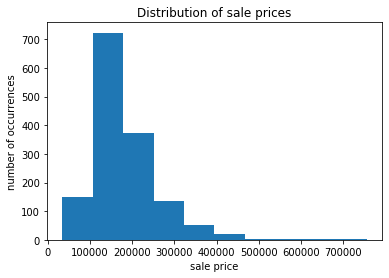

In [5]:
#Exploring distribution
plt.hist(houseprices_df.saleprice)
plt.title("Distribution of sale prices")
plt.xlabel("sale price")
plt.ylabel("number of occurrences")
plt.show()

Distribuiton is non-normal (skewed to the right).

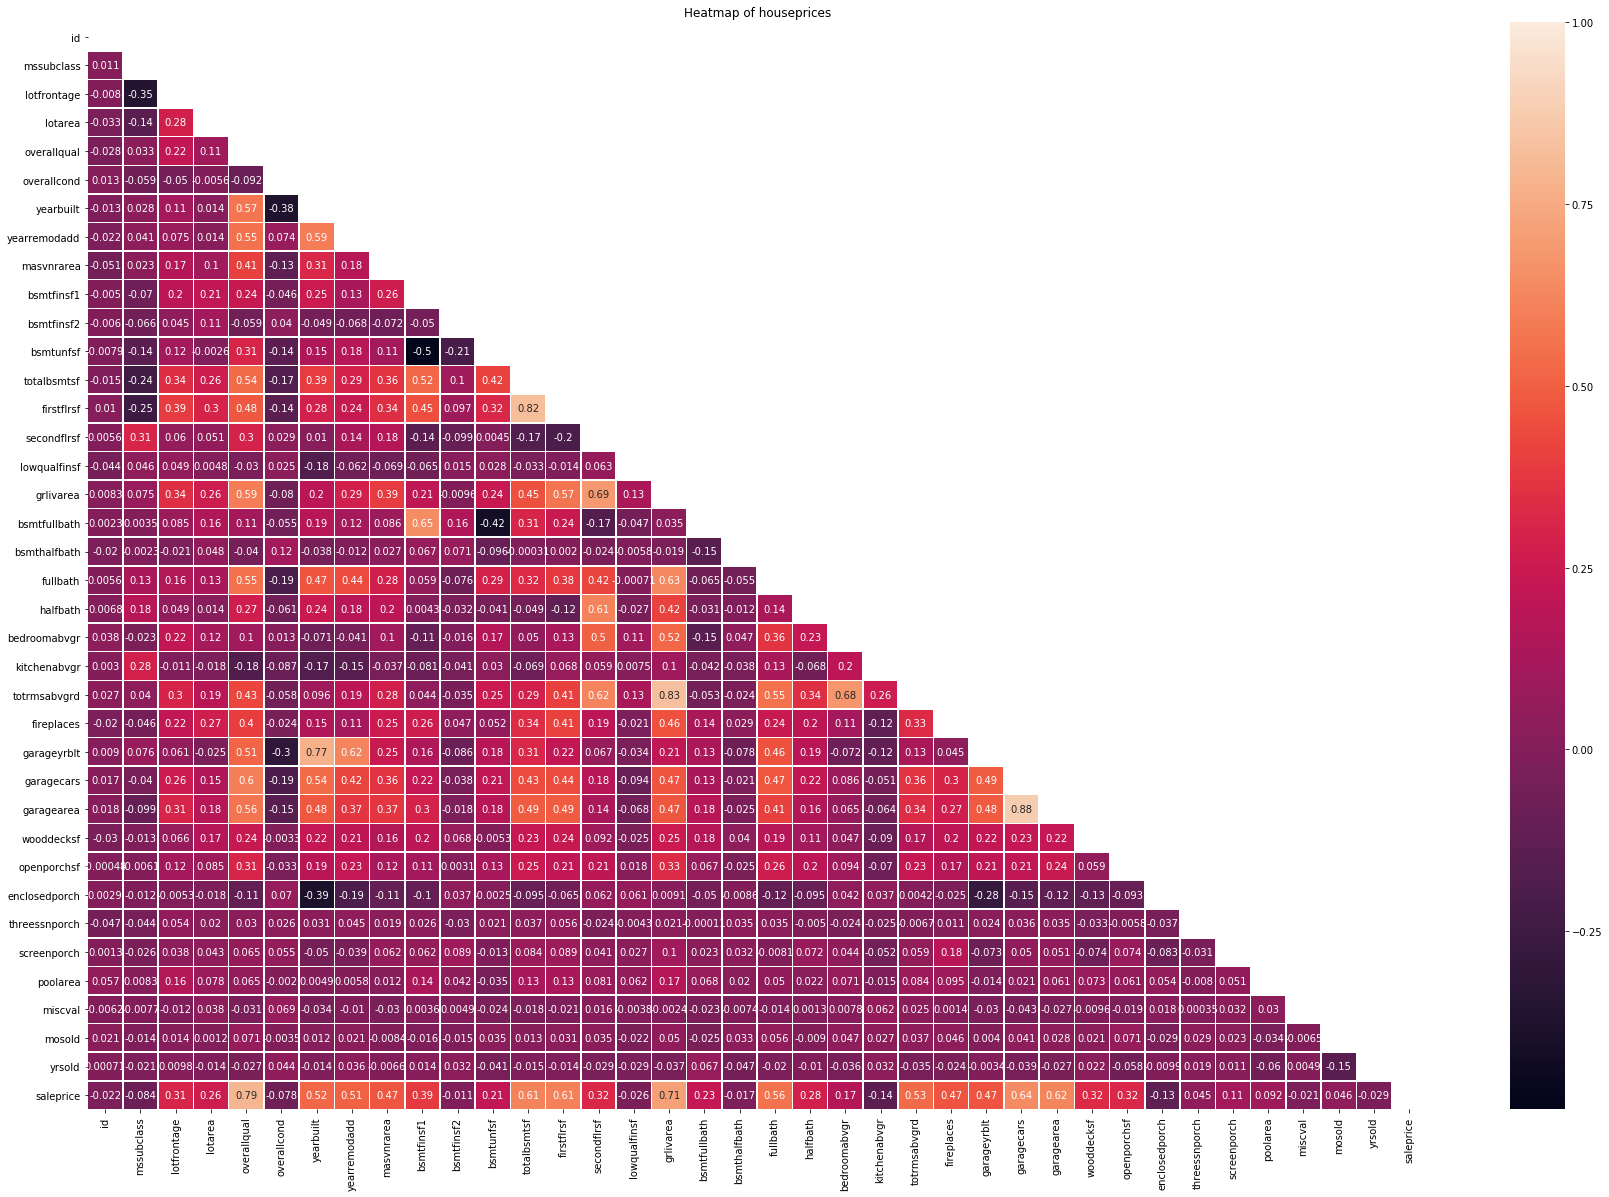

In [6]:
#Create a heatmap of all numeric data
corr = houseprices_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(30,20))
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5)
plt.title('Heatmap of houseprices')
plt.show()

In [7]:
np.abs(houseprices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.474279
garageyrblt      0.467106
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
lotfrontage      0.310557
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Based on the heatmap showing correlations, saleprices can be represented as a function of:

    overallqual 
    grlivarea
    garagecars or garagearea (high correlation of 0.88)
    totalbsmtsf or firstflrsf (high correlation of 0.82)
    
These are the variables with the strongest correlations (corr >= 0.6).

However, this does not yet account for non-numeric variables.

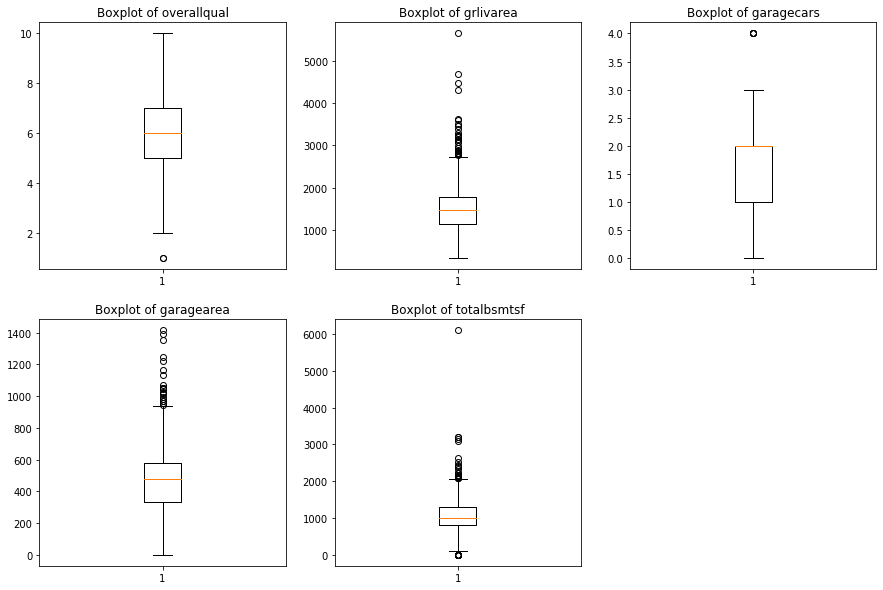

In [8]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.boxplot(houseprices_df['overallqual'])
plt.title("Boxplot of overallqual")

plt.subplot(2,3,2)
plt.boxplot(houseprices_df['grlivarea'])
plt.title("Boxplot of grlivarea")

plt.subplot(2,3,3)
plt.boxplot(houseprices_df['garagecars'])
plt.title("Boxplot of garagecars")

plt.subplot(2,3,4)
plt.boxplot(houseprices_df['garagearea'])
plt.title("Boxplot of garagearea")

plt.subplot(2,3,5)
plt.boxplot(houseprices_df['totalbsmtsf'])
plt.title("Boxplot of totalbsmtsf")
    
plt.show()

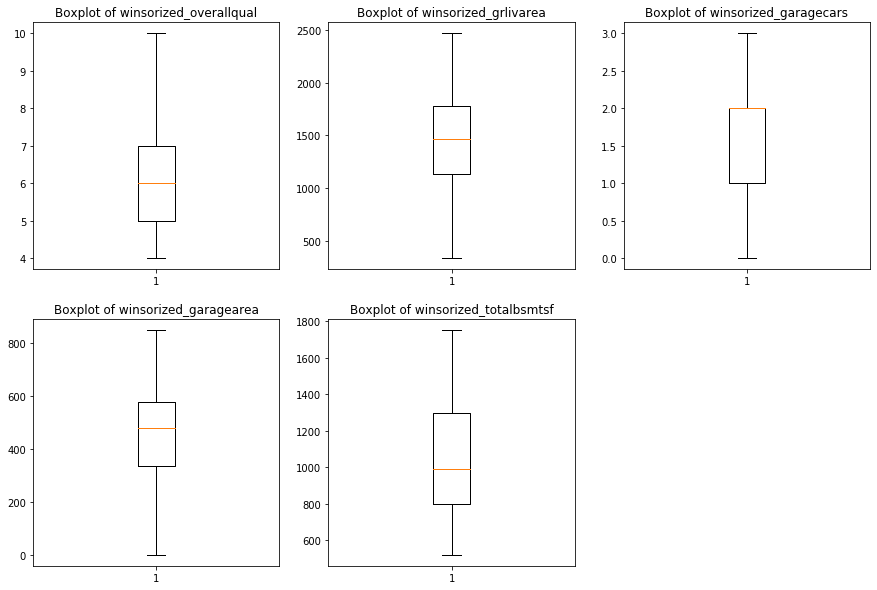

In [9]:
from scipy.stats.mstats import winsorize

houseprices_df['winsorized_overallqual'] = winsorize(houseprices_df.overallqual, (0.05, 0.00))
houseprices_df['winsorized_grlivarea'] = winsorize(houseprices_df.grlivarea, (0.00, 0.05))
houseprices_df['winsorized_garagecars'] = winsorize(houseprices_df.garagecars, (0.00, 0.05))
houseprices_df['winsorized_garagearea'] = winsorize(houseprices_df.garagearea, (0.00, 0.05))
houseprices_df['winsorized_totalbsmtsf'] = winsorize(houseprices_df.totalbsmtsf, (0.05, 0.05))


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.boxplot(houseprices_df['winsorized_overallqual'])
plt.title("Boxplot of winsorized_overallqual")

plt.subplot(2,3,2)
plt.boxplot(houseprices_df['winsorized_grlivarea'])
plt.title("Boxplot of winsorized_grlivarea")

plt.subplot(2,3,3)
plt.boxplot(houseprices_df['winsorized_garagecars'])
plt.title("Boxplot of winsorized_garagecars")

plt.subplot(2,3,4)
plt.boxplot(houseprices_df['winsorized_garagearea'])
plt.title("Boxplot of winsorized_garagearea")

plt.subplot(2,3,5)
plt.boxplot(houseprices_df['winsorized_totalbsmtsf'])
plt.title("Boxplot of winsorized_totalbsmtsf")
    
plt.show()

No outliers remain in potential feature variables.

### EDA and Feature engineering

In [10]:
#need to update non-numeric columns(those with large amounts)
#of missing data were dropped
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns
print(len(non_numeric_columns))

38


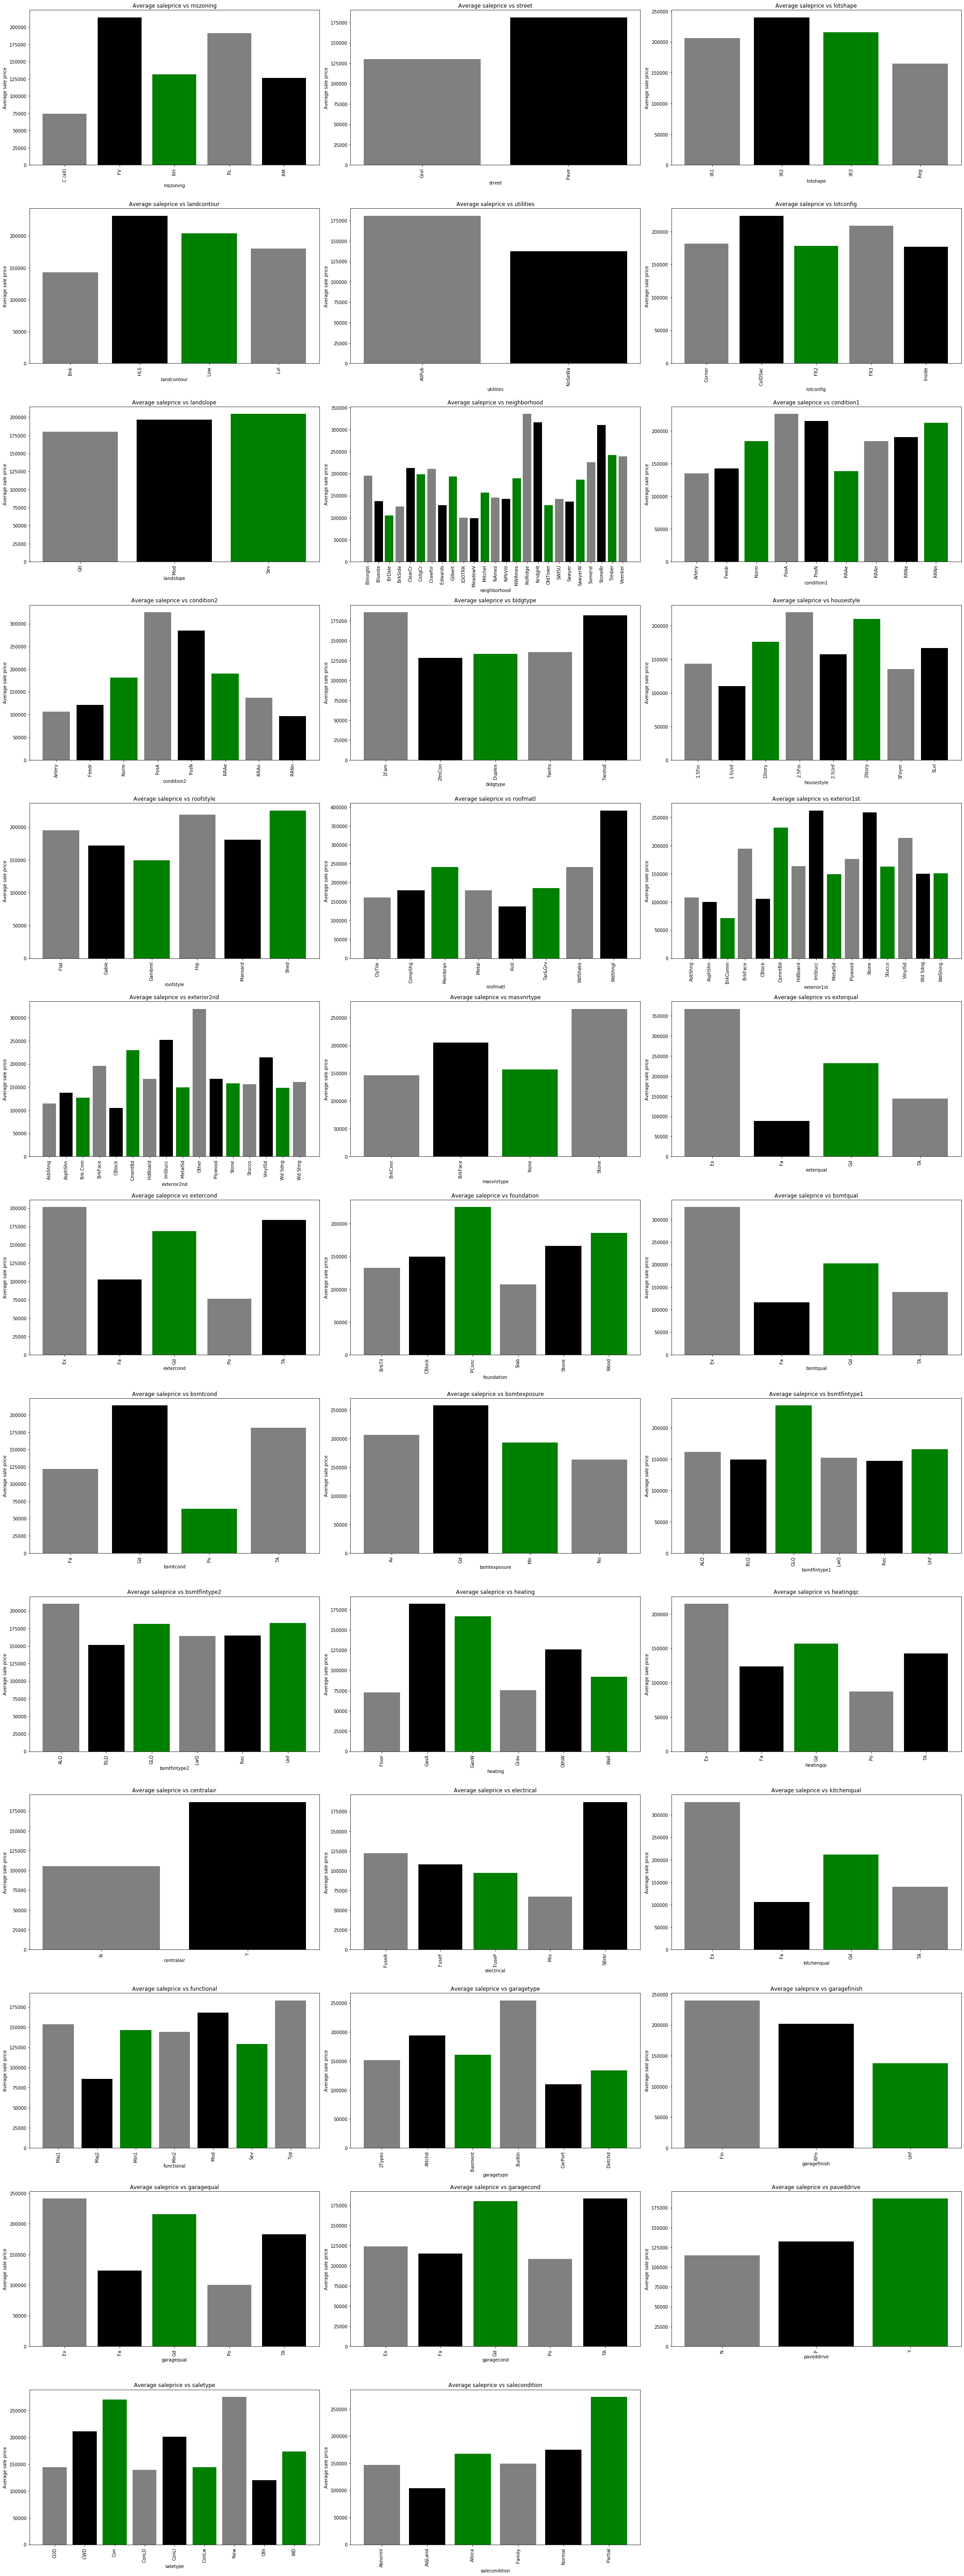

In [11]:
plt.figure(figsize=(30,80))

for index, column in enumerate(non_numeric_columns):
    #There are now 38 non-numeric columns
    plt.subplot(13,3,index+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index,
            houseprices_df.groupby(column)['saleprice'].mean(), 
            color=('gray','black', 'green'))
    plt.title("Average saleprice vs {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Based on numeric and non-numeric features, saleprices can be represented as a function of:

    winsorized_overallqual 
    winsorized_grlivarea
    winsorized_garagecars or winsorized_garagearea
    winsorized_totalbsmtsf

    mszoning
    street
    utilities
    neighborhood
    exterqual
    kitchenqual

### Regression Models

In [12]:
#Selecting the features for categorical variables as a dummy list
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.utilities, prefix="utilities", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.exterqual, prefix="exterqual", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.kitchenqual, prefix="kitchenqual", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.utilities, prefix="utilities", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.neighborhood, prefix="neighborhood", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.exterqual, prefix="exterqual", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.kitchenqual, prefix="kitchenqual", drop_first=True).columns)

In [14]:
#MODEL 1

#Feature set(X)
X = houseprices_df[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_totalbsmtsf'] + dummy_column_names]
#Target variable(Y)
Y = houseprices_df.saleprice

#Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

#Add constant
X_train = sm.add_constant(X_train)
#Fit OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()
#Print results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     146.7
Date:                Fri, 17 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:01:56   Log-Likelihood:                -13759.
No. Observations:                1168   AIC:                         2.760e+04
Df Residuals:                    1127   BIC:                         2.781e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.429e+04   2.57e+04     -0.944      0.345   -7.48e+04    2.62e+04
winsorized_overallqual  1.473e+04   1365.008     10.794      0.000    1.21e+04    1.74e+04
winsorized_grlivarea      46.7874      2.916     16.043      0.000      41.065      52.510
winsorized_garagecars   1.202e+04   1853.535      6.484      0.000    8381.443    1.57e+04
winsorized_totalbsmtsf    34.4085      3.671      9.373      0.000      27.206      41.611
mszoning_FV             4.006e+04   1.69e+04      2.377      0.018    6994.128    7.31e+04
mszoning_RH             2.941e+04   1.68e+04      1.754      0.080   -3483.394    6.23e+04
mszoning_RL             3.972e+04    1.4e+04      2.832      0.005    1.22e+04    6.72e+04
mszoning_RM             2.566e+04   1.32e+04      1.938      0.053    -317.978    5.16e+04
street_Pave            -2005.8586   1.56e+04     -0.129      0.898   -3.26e+04    2.85e+04
utilities_NoSeWa        -4.74e+04   3.28e+04     -1.443      0.149   -1.12e+05     1.7e+04
neighborhood_Blueste     1.11e+04   2.52e+04      0.441      0.659   -3.83e+04    6.05e+04
neighborhood_BrDale     5456.4006   1.38e+04      0.395      0.693   -2.17e+04    3.26e+04
neighborhood_BrkSide    1.693e+04    1.1e+04      1.541      0.124   -4628.717    3.85e+04
neighborhood_ClearCr    2.633e+04   1.13e+04      2.328      0.020    4142.853    4.85e+04
neighborhood_CollgCr    1.902e+04   9240.634      2.058      0.040     888.367    3.71e+04
neighborhood_Crawfor    3.709e+04   1.04e+04      3.579      0.000    1.68e+04    5.74e+04
neighborhood_Edwards    2508.5606   1.01e+04      0.249      0.803   -1.72e+04    2.23e+04
neighborhood_Gilbert    1.787e+04   9829.683      1.818      0.069   -1418.297    3.72e+04
neighborhood_IDOTRR     1.515e+04   1.32e+04      1.148      0.251   -1.07e+04     4.1e+04
neighborhood_MeadowV    2.197e+04   1.38e+04      1.589      0.112   -5162.364    4.91e+04
neighborhood_Mitchel     1.04e+04   1.06e+04      0.983      0.326   -1.04e+04    3.12e+04
neighborhood_NAmes      1.015e+04   9514.352      1.066      0.286   -8522.183    2.88e+04
neighborhood_NPkVill   -2672.8295    1.6e+04     -0.167      0.868   -3.41e+04    2.88e+04
neighborhood_NWAmes     5219.9331      1e+04      0.521      0.603   -1.44e+04    2.49e+04
neighborhood_NoRidge    8.343e+04   1.05e+04      7.930      0.000    6.28e+04    1.04e+05
neighborhood_NridgHt     4.58e+04   9745.233      4.700      0.000    2.67e+04    6.49e+04
neighborhood_OldTown    3237.4054   1.09e+04      0.297      0.766   -1.81e+04    2.46e+04
neighborhood_SWISU     -2697.2537   1.19e+04     -0.226      0.821   -2.61e+04    2.07e+04
neighborhood_Sawyer     1.138e+04   1.02e+04      1.121      0.263   -8549.282    3.13e+04
neighborhood_SawyerW    1.256e+04   1.01e+04      1.244      0.214   -7243.849  

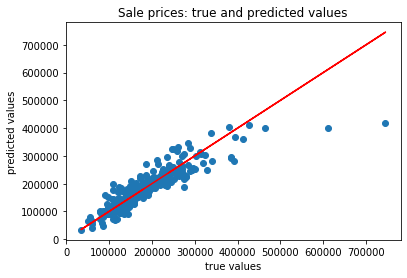

Mean absolute error of the prediction is: 23204.68781712969
Mean squared error of the prediction is: 1385096323.475839
Root mean squared error of the prediction is: 37216.882237444865
Mean absolute percentage error of the prediction is: 12.844274212385493


In [15]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

#Make predictions using predict() function
y_preds = results.predict(X_test)

#Model graph
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title('Sale prices: true and predicted values')
plt.show()

#Evaluation metrics
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [16]:
#MODEL 2

#Feature set(X)
X = houseprices_df[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_totalbsmtsf'] + dummy_column_names]
#Log transform the target variable(Y)
Y = np.log1p(houseprices_df.saleprice)

#Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

#Add constant
X_train = sm.add_constant(X_train)
#Fit OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()
#Print results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     180.0
Date:                Fri, 17 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:08:58   Log-Likelihood:                 589.77
No. Observations:                1168   AIC:                            -1098.
Df Residuals:                    1127   BIC:                            -889.9
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10.6234      0.119     89.382      0.000      10.390      10.857
winsorized_overallqual     0.0792      0.006     12.563      0.000       0.067       0.092
winsorized_grlivarea       0.0003   1.35e-05     19.717      0.000       0.000       0.000
winsorized_garagecars      0.0703      0.009      8.215      0.000       0.054       0.087
winsorized_totalbsmtsf     0.0002    1.7e-05     10.717      0.000       0.000       0.000
mszoning_FV                0.4196      0.078      5.390      0.000       0.267       0.572
mszoning_RH                0.3078      0.077      3.974      0.000       0.156       0.460
mszoning_RL                0.3863      0.065      5.961      0.000       0.259       0.513
mszoning_RM                0.3138      0.061      5.130      0.000       0.194       0.434
street_Pave               -0.1018      0.072     -1.416      0.157      -0.243       0.039
utilities_NoSeWa          -0.2338      0.152     -1.541      0.124      -0.531       0.064
neighborhood_Blueste       0.0360      0.116      0.310      0.757      -0.192       0.264
neighborhood_BrDale       -0.0880      0.064     -1.378      0.168      -0.213       0.037
neighborhood_BrkSide       0.0165      0.051      0.325      0.745      -0.083       0.116
neighborhood_ClearCr       0.1362      0.052      2.607      0.009       0.034       0.239
neighborhood_CollgCr       0.0875      0.043      2.049      0.041       0.004       0.171
neighborhood_Crawfor       0.1739      0.048      3.632      0.000       0.080       0.268
neighborhood_Edwards      -0.0488      0.047     -1.049      0.295      -0.140       0.042
neighborhood_Gilbert       0.0949      0.045      2.090      0.037       0.006       0.184
neighborhood_IDOTRR       -0.0468      0.061     -0.768      0.442      -0.166       0.073
neighborhood_MeadowV      -0.0396      0.064     -0.620      0.535      -0.165       0.086
neighborhood_Mitchel       0.0421      0.049      0.861      0.389      -0.054       0.138
neighborhood_NAmes         0.0377      0.044      0.857      0.391      -0.049       0.124
neighborhood_NPkVill      -0.0254      0.074     -0.343      0.732      -0.171       0.120
neighborhood_NWAmes        0.0291      0.046      0.629      0.530      -0.062       0.120
neighborhood_NoRidge       0.2033      0.049      4.182      0.000       0.108       0.299
neighborhood_NridgHt       0.1497      0.045      3.325      0.001       0.061       0.238
neighborhood_OldTown      -0.0788      0.050     -1.566      0.118      -0.178       0.020
neighborhood_SWISU        -0.0206      0.055     -0.373      0.709      -0.129       0.088
neighborhood_Sawyer        0.0310      0.047      0.660      0.509      -0.061       0.123
neighborhood_SawyerW       0.0406      0.047      0.872      0.384      -0.051  

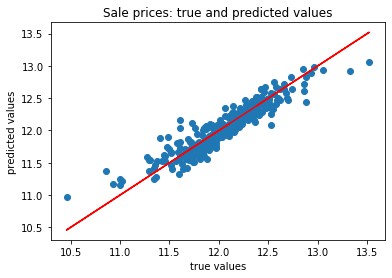

Mean absolute error of the prediction is: 0.11330083492151033
Mean squared error of the prediction is: 0.02282991261840647
Root mean squared error of the prediction is: 0.15109570681659512
Mean absolute percentage error of the prediction is: 0.9473702255283273


In [17]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

#Make predictions using predict() function
y_preds = results.predict(X_test)

#Model graph
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title('Sale prices: true and predicted values')
plt.show()

#Evaluation metrics
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

For all four metrics (MAE, MSE, RMSE, MAPE), the test set performance is Model 2 is better than Model 1. In addition, Model 1 predicts lower values better than higher values. However, Model 2 more evenly and accurately predicts all values. Model 2 appears to be the right choice, based on visual and statistical test performance.